In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [5]:
import os
import numpy as np
import torch

import cv2
import matplotlib.pyplot as plt

from particle_detection.data.dataset import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.autoencoder.utils import load_model

In [3]:
data_dir = "/home/blah-buttery/nanoparticles/images/normal"
image_size = (1024, 1024)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [6]:
# Path to the trained model
model_path = "../saved_models/ae_1000_epochs.pth"

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create and load the model
autoencoder = create_autoencoder().to(device)
autoencoder = load_model(autoencoder, model_path, device=device)
autoencoder.eval() 

[DEBUG] Loading model from: ../saved_models/ae_1000_epochs.pth
[DEBUG] Model loaded successfully from ../saved_models/ae_1000_epochs.pth.


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

Original image shape: torch.Size([3, 1024, 1024])
Reconstructed image shape: torch.Size([3, 1024, 1024])


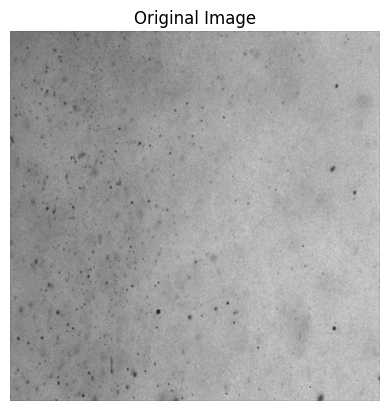

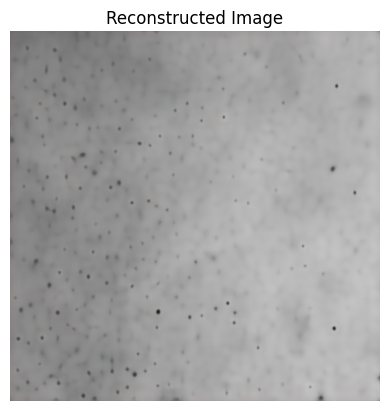

In [7]:
# Forward pass sample_img through our trained model
sample_img = next(iter(test_loader))  # Get a batch of test images
sample_img = sample_img.to(device)

with torch.no_grad():
    reconstructed_img = autoencoder(sample_img)

# Handling batch dimensions to take the first image
sample_img = sample_img[0]  # Take the first image in the batch
print(f"Original image shape: {sample_img.shape}")
reconstructed_img = reconstructed_img[0]
print(f"Reconstructed image shape: {reconstructed_img.shape}")

# Clamp values to ensure valid image range
sample_img = torch.clamp(sample_img, min=0, max=1)
reconstructed_img = torch.clamp(reconstructed_img, min=0, max=1)

# Function to display images (works for both grayscale and RGB)
def display_image(tensor, image_type="grayscale", title="Image"):
    """
    Displays an image from a PyTorch tensor.

    Args:
    - tensor (torch.Tensor): The image tensor (C, H, W).
    - image_type (str): "grayscale" for single-channel, "rgb" for multi-channel.
    - title (str): Title of the displayed image.
    """
    tensor = tensor.cpu().detach().numpy()

    if image_type == "grayscale":
        plt.imshow(tensor.squeeze(), cmap="gray")
    elif image_type == "rgb":
        # Transpose to HWC for RGB
        tensor = tensor.transpose(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError(f"Invalid image_type: {image_type}. Use 'grayscale' or 'rgb'.")

    plt.axis("off")
    plt.title(title)
    plt.show()

# Display original and reconstructed images
image_type = "rgb"  # "rgb" for RGB images or "grayscale"
display_image(sample_img, image_type=image_type, title="Original Image")
display_image(reconstructed_img, image_type=image_type, title="Reconstructed Image")

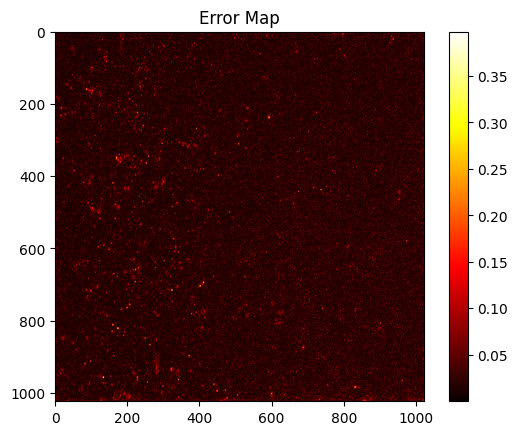

In [13]:
# Error map for RGB images
# Compute the mean error across the color channels (dim=1 corresponds to the channel dimension)
error_map = torch.abs(sample_img - reconstructed_img).mean(dim=1).cpu().numpy()

# Display the error map for the first sample in the batch
error_map_image = error_map[0]
plt.imshow(error_map_image, cmap="hot")
plt.colorbar()
plt.title("Error Map")
plt.show()

The errors are the small particles and background noise, so the issue is that the model is too good to use for error contouring.

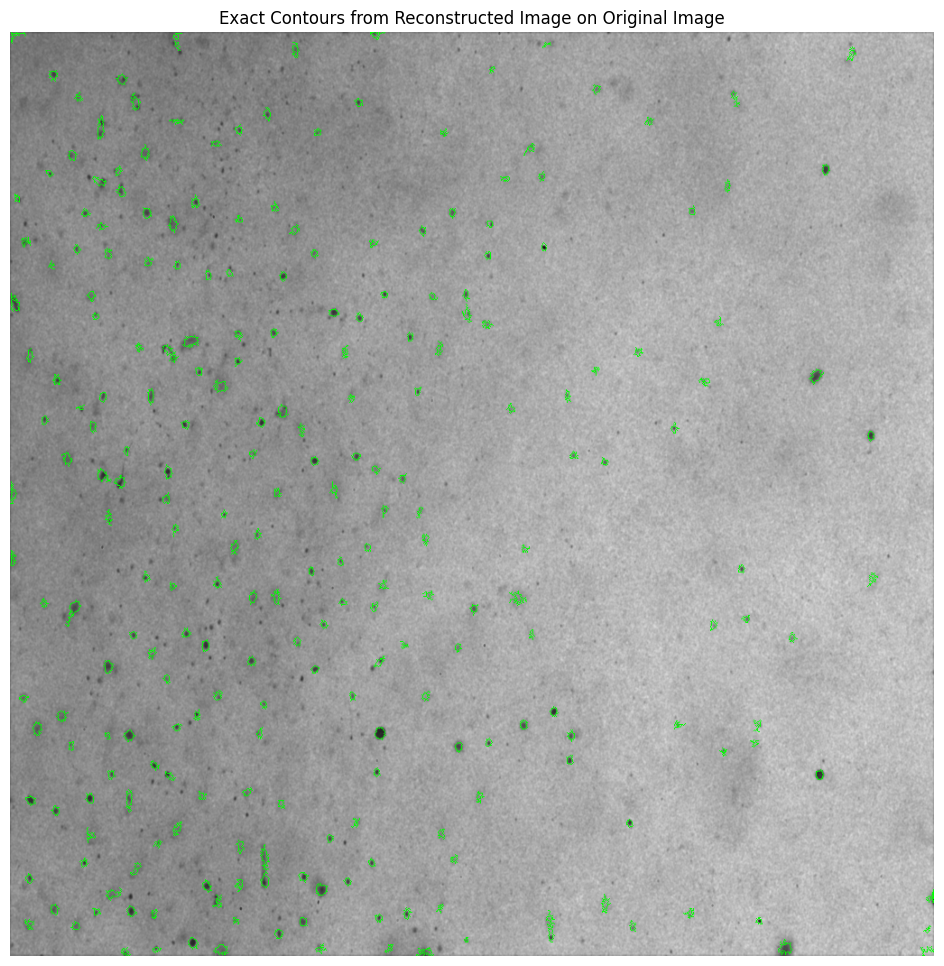

Total contours found: 40398
Valid particles detected: 252


In [14]:
def overlay_exact_contours_on_original(reconstructed_img, original_img, min_area=10, max_area=1000):
    """
    Detect exact contours on the reconstructed image and overlay them on the original image.

    Args:
        reconstructed_img (torch.Tensor): Reconstructed image tensor, shape [1, 1, H, W].
        original_img (torch.Tensor): Original image tensor, shape [1, 1, H, W].
        min_area (int): Minimum particle area to be considered valid.
        max_area (int): Maximum particle area to be considered valid.

    Returns:
        None: Displays the original image with exact contours overlaid.
    """
    # Step 1: Convert tensors to NumPy
    if isinstance(reconstructed_img, torch.Tensor):
        reconstructed_img = reconstructed_img[0, 0].cpu().numpy()
    if isinstance(original_img, torch.Tensor):
        original_img = original_img[0, 0].cpu().numpy()

    # Step 2: Normalize and scale the reconstructed image to [0, 255]
    reconstructed_scaled = (reconstructed_img * 255).astype(np.uint8)

    # Step 3: Apply adaptive thresholding
    thresholded_img = cv2.adaptiveThreshold(
        reconstructed_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Step 4: Find contours on the thresholded reconstructed image
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Filter contours by area
    valid_contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    # Step 6: Prepare the original image for visualization
    original_colored = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Step 7: Overlay exact contours on the original image
    cv2.drawContours(original_colored, valid_contours, -1, (0, 255, 0), thickness=1)

    # Display the results
    plt.figure(figsize=(12, 12))
    plt.imshow(original_colored)
    plt.title("Exact Contours from Reconstructed Image on Original Image")
    plt.axis("off")
    plt.show()

    print(f"Total contours found: {len(contours)}")
    print(f"Valid particles detected: {len(valid_contours)}")

# Example Usage
overlay_exact_contours_on_original(reconstructed_img, sample_img, min_area=10, max_area=1000)

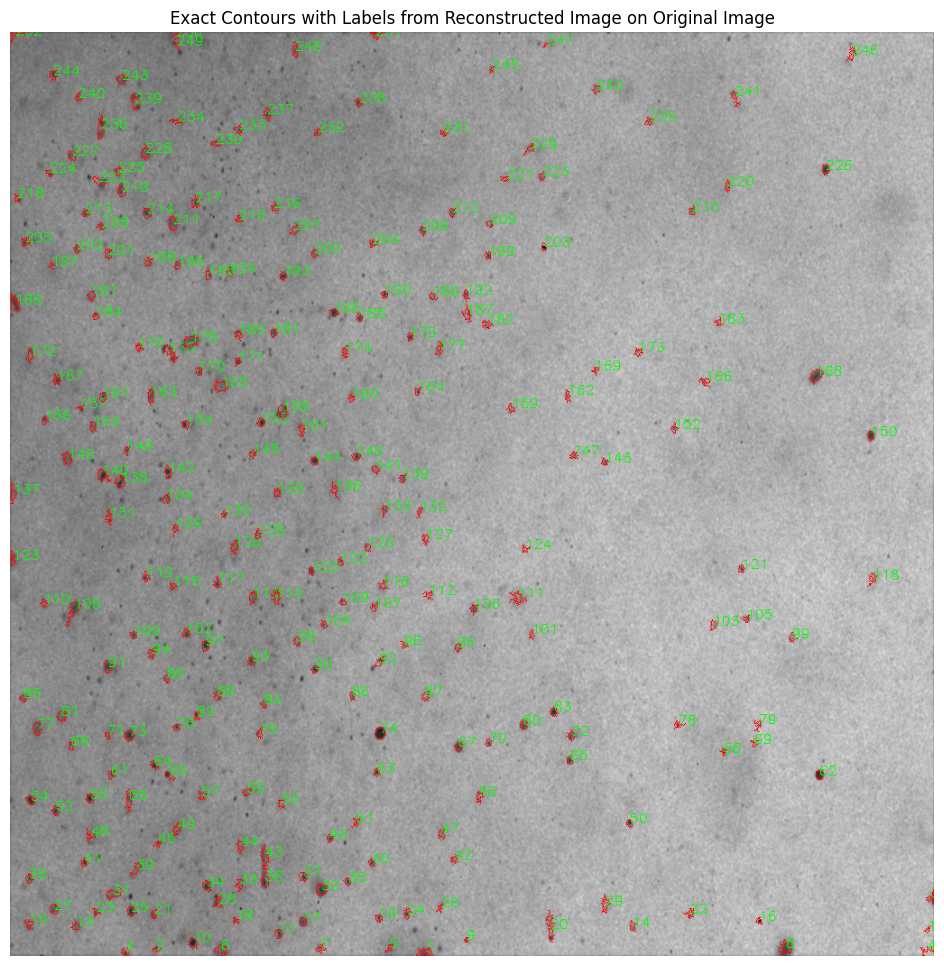

Total contours found: 40398
Valid particles detected: 252


In [15]:
def overlay_exact_contours_on_original(reconstructed_img, original_img, min_area=10, max_area=1000):
    """
    Detect exact contours on the reconstructed image and overlay them on the original image with labels.

    Args:
        reconstructed_img (torch.Tensor): Reconstructed image tensor, shape [1, 1, H, W].
        original_img (torch.Tensor): Original image tensor, shape [1, 1, H, W].
        min_area (int): Minimum particle area to be considered valid.
        max_area (int): Maximum particle area to be considered valid.

    Returns:
        None: Displays the original image with exact contours overlaid.
    """
    # Step 1: Convert tensors to NumPy
    if isinstance(reconstructed_img, torch.Tensor):
        reconstructed_img = reconstructed_img[0, 0].cpu().numpy()
    if isinstance(original_img, torch.Tensor):
        original_img = original_img[0, 0].cpu().numpy()

    # Step 2: Normalize and scale the reconstructed image to [0, 255]
    reconstructed_scaled = (reconstructed_img * 255).astype(np.uint8)

    # Step 3: Apply adaptive thresholding
    thresholded_img = cv2.adaptiveThreshold(
        reconstructed_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Step 4: Find contours on the thresholded reconstructed image
    contours, _ = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 5: Filter contours by area
    valid_contours = [c for c in contours if min_area <= cv2.contourArea(c) <= max_area]

    # Step 6: Prepare the original image for visualization
    original_colored = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Step 7: Overlay exact contours and labels on the original image
    for i, contour in enumerate(valid_contours):
        # Draw the red contour
        cv2.drawContours(original_colored, [contour], -1, (0, 0, 255), thickness=1)  # Red color

        # Calculate the center of the contour for labeling
        M = cv2.moments(contour)
        if M["m00"] != 0:  # Avoid division by zero
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # Add the label (number) near the contour
            cv2.putText(
                original_colored, str(i + 1), (cX, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), thickness=1  # Green for text
            )

    # Display the results
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(original_colored, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Exact Contours with Labels from Reconstructed Image on Original Image")
    plt.axis("off")
    plt.show()

    print(f"Total contours found: {len(contours)}")
    print(f"Valid particles detected: {len(valid_contours)}")

# Example Usage
overlay_exact_contours_on_original(reconstructed_img, sample_img, min_area=10, max_area=1000)